# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
!pip install pandas scikit-learn matplotlib

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')

In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)


In [7]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [8]:
id2word = {i:word for word, i in word2id.items()}

In [9]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [12]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [13]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [15]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

In [16]:
def plot_model(model):
  val = model.history.history['val_f1'][-1]
  train = model.history.history['f1'][-1]
  print('F1: \nval = ',val, 'train = ', train)
  # summarize history for accuracy
  plt.plot(model.history.history['rec@prec'])
  plt.plot(model.history.history['val_rec@prec'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## модель с 1 GRU слоем

Model: "1_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786,681
Trainable params: 786,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
43/43 [==============================] - 15s 62ms/step - loss: 2.6061 - f1: 0.0050 - rec@prec: 0.0000e+00 - val_loss: 2.3612 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epo

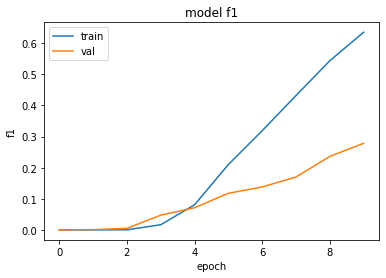

In [17]:
rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="1_GRU")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)


## модель с 1 LSTM слоем

Model: "1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense_1 (Dense)             (None, 19)                2451      
                                                                 
Total params: 806,649
Trainable params: 806,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
43/43 [==============================] - 5s 72ms/step - loss: 2.4343 - f1: 0.0000e+00 - rec@prec: 0.0046 - val_loss: 2.1918 - val_f1: 0.0000e+00 - val_rec@prec: 0.0198
Epoch 2

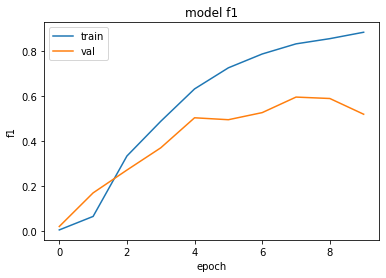

In [18]:
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="1_LSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)

## модель с 1 GRU и 1 LSTM слоем

Model: "1_GRU_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 19)                1235      
                                                                 
Total params: 912,761
Trainable params: 912,761
Non-tr

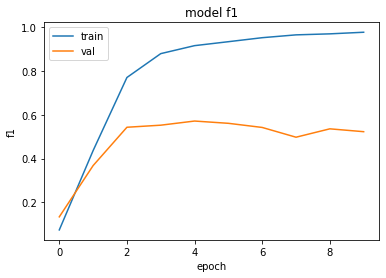

In [19]:

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="1_GRU_1_LSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)

## модель с 1 BIGRU и 2 LSTM слоями

Model: "1_BIGRU_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         122880    
 l)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          197120    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                    

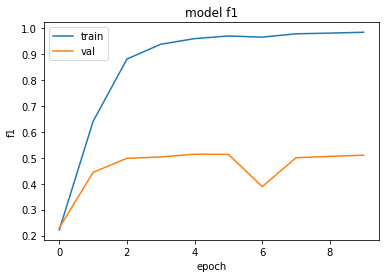

In [20]:
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="1_BIGRU_2_LSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)


## модель с 5 GRU слоями и 3 LSTM слоями

Model: "5_GRU_3_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru_3 (GRU)                 (None, 200, 128)          61440     
                                                                 
 gru_4 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_5 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_6 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_7 (GRU)                 (None, 200, 128)         

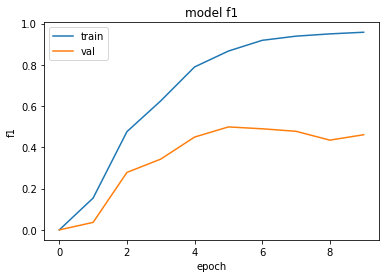

In [21]:
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="5_GRU_3_LSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)

## модель с 1 BIGRU и 1 BILSTM слоями

Model: "1_BIGRU_1_BILSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 64)          12288     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 19)           

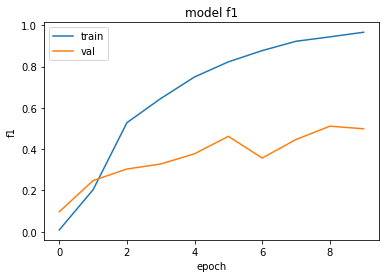

In [22]:
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True),
                                      backward_layer=tf.keras.layers.GRU(128, return_sequences=True,
                                                                         go_backwards=True))(embeddings)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False),
                                      backward_layer=tf.keras.layers.LSTM(128, return_sequences=False,
                                                                         go_backwards=True))(bigru)

dense = tf.keras.layers.Dense(64, activation='relu')(bilstm)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="1_BIGRU_1_BILSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)

## модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

Model: "LSTM_GRU_BILSTM_BIGRU_GRU_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 lstm_9 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_10 (GRU)                (None, 200, 128)          99072     
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 256)         296448    
 nal)                               

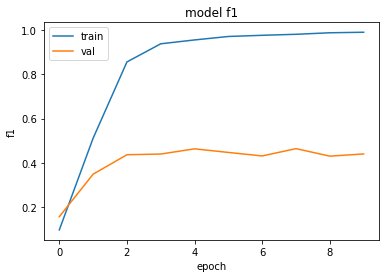

In [23]:
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)


dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="LSTM_GRU_BILSTM_BIGRU_GRU_LSTM")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.summary()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, epochs=10, verbose=1)

plot_model(model)

Лучше всего себя показала модель с 1 GRU и 1 LSTM слоем

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [139]:
! pip install navec

In [140]:
! pip install slovnet

In [141]:
from navec import Navec
import torch
from slovnet.model.emb import NavecEmbedding
from datasets import load_dataset

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [142]:
dataset = load_dataset("wikiann", 'ru')

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [143]:
vocab = Counter()

for sent in dataset['train']['tokens']:
  vocab.update([x.lower() for x in sent])
word2id = {'<pad>':0, '<unk>':1}
for word in vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}


X = []
for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)
X_test = []
for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)


MAX_LEN = max(len(x) for x in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'<pad>'}
label2id = {v:k for k,v in id2labels.items()} 
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

# предобученные эмбединги слов и несколько BILSTM слоев

In [144]:
emb = NavecEmbedding(navec)
ebmedding_matrix = np.zeros((len(word2id), 300))

for word, i in word2id.items():

    try:
        idx = navec.vocab[word]
        ebmedding_matrix[i]  = emb(np.array(idx))
    
    
    except KeyError:
      idx = navec.vocab['<unk>']
      ebmedding_matrix[i]  = emb(np.array(idx))
      


In [146]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 

embeddings = tf.keras.layers.Embedding(len(word2id),
                        300,
                        weights=[ebmedding_matrix],
                        input_length=MAX_LEN,
                        trainable=False)(inputs)

In [147]:
lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 17s 60ms/step - loss: 0.2191 - accuracy: 0.9414 - val_loss: 0.1038 - val_accuracy: 0.9657
Epoch 2/5
157/157 [==============================] - 7s 45ms/step - loss: 0.0796 - accuracy: 0.9743 - val_loss: 0.0704 - val_accuracy: 0.9785
Epoch 3/5
157/157 [==============================] - 7s 42ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0596 - val_accuracy: 0.9813
Epoch 4/5
157/157 [==============================] - 7s 45ms/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.0572 - val_accuracy: 0.9830
Epoch 5/5
157/157 [==============================] - 10s 64ms/step - loss: 0.0407 - accuracy: 0.9873 - val_loss: 0.0578 - val_accuracy: 0.9813


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


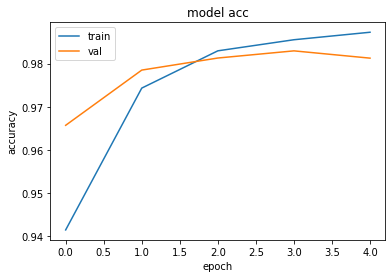

In [149]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# предобученные эмбединги слов и несколько BIGRU слоев

In [150]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,)) 

embeddings = tf.keras.layers.Embedding(len(word2id),
                        300,
                        weights=[ebmedding_matrix],
                        input_length=MAX_LEN,
                        trainable=False)(inputs)
gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_1)
gru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_3)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

model2.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 19s 67ms/step - loss: 0.1869 - accuracy: 0.9546 - val_loss: 0.0795 - val_accuracy: 0.9750
Epoch 2/5
157/157 [==============================] - 8s 49ms/step - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.0634 - val_accuracy: 0.9798
Epoch 3/5
157/157 [==============================] - 6s 39ms/step - loss: 0.0510 - accuracy: 0.9839 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 4/5
157/157 [==============================] - 6s 37ms/step - loss: 0.0436 - accuracy: 0.9863 - val_loss: 0.0539 - val_accuracy: 0.9833
Epoch 5/5
157/157 [==============================] - 6s 40ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0523 - val_accuracy: 0.9838


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


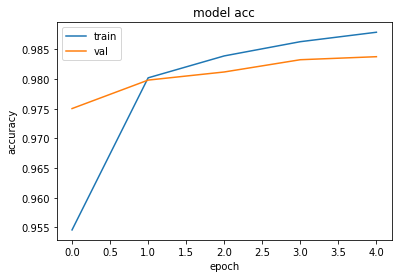

In [151]:
print(model2.history.history.keys())
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [154]:
sentence = 'Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.'
print('BILSTM')
print(label_seq(sentence, word2id, id2labels, MAX_LEN, model))
print('BIGRU')
print(label_seq(sentence, word2id, id2labels, MAX_LEN, model2))


BILSTM
[('Алексей', 'B-PER'), ('сказал', 'I-PER'), ('Светлане', 'I-PER'), (',', 'O'), ('чтобы', 'O'), ('она', 'O'), ('собиралась', 'O'), ('на', 'O'), ('поезд', 'O'), ('в', 'O'), ('Москву', 'B-LOC'), ('.', 'O')]
BIGRU
[('Алексей', 'B-PER'), ('сказал', 'I-PER'), ('Светлане', 'O'), (',', 'O'), ('чтобы', 'O'), ('она', 'O'), ('собиралась', 'O'), ('на', 'O'), ('поезд', 'O'), ('в', 'O'), ('Москву', 'B-LOC'), ('.', 'O')]


In [155]:
sentence = 'Иван да Марья гуляли в Коломенском парке.'
print('BILSTM')
print(label_seq(sentence, word2id, id2labels, MAX_LEN, model))
print('BIGRU')
print(label_seq(sentence, word2id, id2labels, MAX_LEN, model2))

BILSTM
[('Иван', 'B-PER'), ('да', 'I-PER'), ('Марья', 'I-PER'), ('гуляли', 'I-PER'), ('в', 'O'), ('Коломенском', 'O'), ('парке', 'O'), ('.', 'O')]
BIGRU
[('Иван', 'B-PER'), ('да', 'I-PER'), ('Марья', 'O'), ('гуляли', 'O'), ('в', 'O'), ('Коломенском', 'O'), ('парке', 'O'), ('.', 'O')]


Все выглядит так как будто бы BILSTM показывает результаты немного лучше, в частности в распознавании имен, но надо проверить на тестовых данных

In [158]:
from sklearn.metrics import classification_report

In [175]:
pred = model.predict(X_test)
print(classification_report(y_test.reshape(-1), np.argmax(pred, axis=2).reshape(-1),
                                                                     target_names=list(id2labels.values())))

              precision    recall  f1-score   support

           O       0.92      0.92      0.92     40480
       B-PER       0.82      0.85      0.83      3542
       I-PER       0.83      0.92      0.87      7544
       B-ORG       0.67      0.64      0.65      4074
       I-ORG       0.76      0.76      0.76      8008
       B-LOC       0.80      0.70      0.75      4560
       I-LOC       0.77      0.74      0.75      3060
       <pad>       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.81      0.82    540000
weighted avg       0.98      0.98      0.98    540000



In [176]:
pred = model2.predict(X_test)
print(classification_report(y_test.reshape(-1), np.argmax(pred, axis=2).reshape(-1),
                                                                     target_names=list(id2labels.values())))

              precision    recall  f1-score   support

           O       0.89      0.97      0.93     40480
       B-PER       0.89      0.83      0.86      3542
       I-PER       0.93      0.88      0.91      7544
       B-ORG       0.78      0.60      0.68      4074
       I-ORG       0.88      0.69      0.77      8008
       B-LOC       0.75      0.76      0.76      4560
       I-LOC       0.80      0.74      0.77      3060
       <pad>       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.87      0.81      0.83    540000
weighted avg       0.98      0.98      0.98    540000



Судя по тестовым данным, у BIGRU результаты лучше